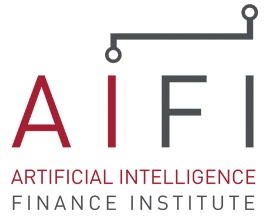


# Bootcamp - Python and Coding - Primer

## Testing and software patterns

# About this Notebook

This is a short overview how to test your code and how you can simplify the code and ensure the maintainability and reusability of your code with software design patterns. 

# Imports

In [1]:
import numpy as np  
import pandas as pd
import unittest
import yfinance as yf
import requests
import unittest
from unittest.mock import patch
from unittest.mock import Mock
from unittest.mock import MagicMock
import time

## Unit tests

The following is just a very simple example of a `unittest TestCase`, here is a [link](https://docs.python.org/3/library/unittest.html) to the documention how to create `unittest` in Python. 


In this notebook, we define two classes, StockMarket and StockBroker.

The StockMarket class represents a simple model of a stock market with a set of symbols and their current prices. It provides two methods, price_stream() to simulate a price stream for a specific symbol and market_stream() to simulate a market price stream for all symbols.

The StockBroker class represents a stock broker operating in a given market. The broker has a name and methods to track the prices from the market stream (track_prices()) and to buy a stock if its price is below a certain threshold (buy_low()).

For simplicity, some methods in both classes return or operate on the current state of the object without any further complexity (like real-time data or advanced buying strategies). However, they could be extended to include more advanced features or realistic behaviors.

This notebook also contains code for unit testing the StockMarket and StockBroker classes. It ensures the correctness of various methods in these classes, like price_stream(), market_stream(), track_prices(), and buy_low().

The setUp() method is used in each test class to set up the testing context.

Each test method tests a particular functionality of the classes:

- For the StockMarket class, we test if the provided stock symbols are correctly initialized, if the price_stream() method returns a float value for a given symbol, and if the market_stream() method returns a dictionary with stock symbols as keys and their corresponding prices as float values.

- For the StockBroker class, we test if the track_prices() method can correctly track the prices from the market stream and if the buy_low() method can correctly make a purchase when a given stock's price drops below a certain threshold.

We run these tests within Jupyter notebook using unittest.main(), with special arguments to avoid issues unique to Jupyter notebook environment. You would have to call it like this: `unittest.main()` with just a Python script. 

In [2]:
class StockMarket:

    def __init__(self, symbols):

        self.symbols = symbols
        self.current_prices = {symbol: 0.0 for symbol in symbols}

    def price_stream(self, symbol):

        # For simplicity, this method currently just returns the current price.
        return self.current_prices[symbol]

    def market_stream(self): 
        # For simplicity, this method currently just returns the current prices.
        return self.current_prices

In [3]:
class StockBroker:

    def __init__(self, name, market):

        self.name = name
        self.market = market
        self.last_tracked_price = None
        self.last_bought_stock = None

    def track_prices(self, market_stream):

        # For simplicity, this method currently just stores the last tracked price.
        self.last_tracked_price = list(market_stream.items())[-1]

    def buy_low(self, market_stream, symbol, threshold):

        # For simplicity, this method currently buys the stock if its price is below the threshold.
        if market_stream[symbol] < threshold:
            self.last_bought_stock = (symbol, market_stream[symbol])

In [4]:
class TestStockMarket(unittest.TestCase):
    """
    Test Class for StockMarket.
    """

    def setUp(self):

        self.market = StockMarket(['AAPL', 'GOOG', 'TSLA'])

    def test_stock_symbols(self):

        self.assertEqual(['AAPL', 'GOOG', 'TSLA'], self.market.symbols)

    def test_price_stream(self):

        stream = self.market.price_stream('AAPL')
        self.assertIsInstance(stream, float)

    def test_market_stream(self):

        stream = self.market.market_stream()
        last_symbol = list(stream.keys())[-1]
        last_price = stream[last_symbol]
        self.assertIsInstance(last_symbol, str)
        self.assertIsInstance(last_price, float)

In [5]:
class TestStockBroker(unittest.TestCase):

    def setUp(self):
        self.market = StockMarket(['AAPL', 'GOOG', 'TSLA'])
        self.broker = StockBroker('Elon', self.market)

    def test_track_prices(self):
        self.broker.track_prices(self.market.market_stream())
        last_tracked = self.broker.last_tracked_price
        self.assertIsInstance(last_tracked, tuple)
        self.assertIn(last_tracked[0], ['AAPL', 'GOOG', 'TSLA'])
        self.assertIsInstance(last_tracked[1], float)

    def test_buy_low(self):
        threshold = 150.0
        self.broker.buy_low(self.market.market_stream(), 'AAPL', threshold)
        last_bought = self.broker.last_bought_stock
        if last_bought:
            self.assertEqual(last_bought[0], 'AAPL')
            self.assertLess(last_bought[1], threshold)

if __name__ == '__main__':
    # Use this special invocation to run the test cases in the Jupyter notebook. 
    # The argument list is started with an ignored string, since Jupyter might pass its own arguments
    # when unittest.main() is used.
    unittest.main(argv=['first-arg-is-ignored'], exit=False)


.....
----------------------------------------------------------------------
Ran 5 tests in 0.001s

OK


# Mock testing

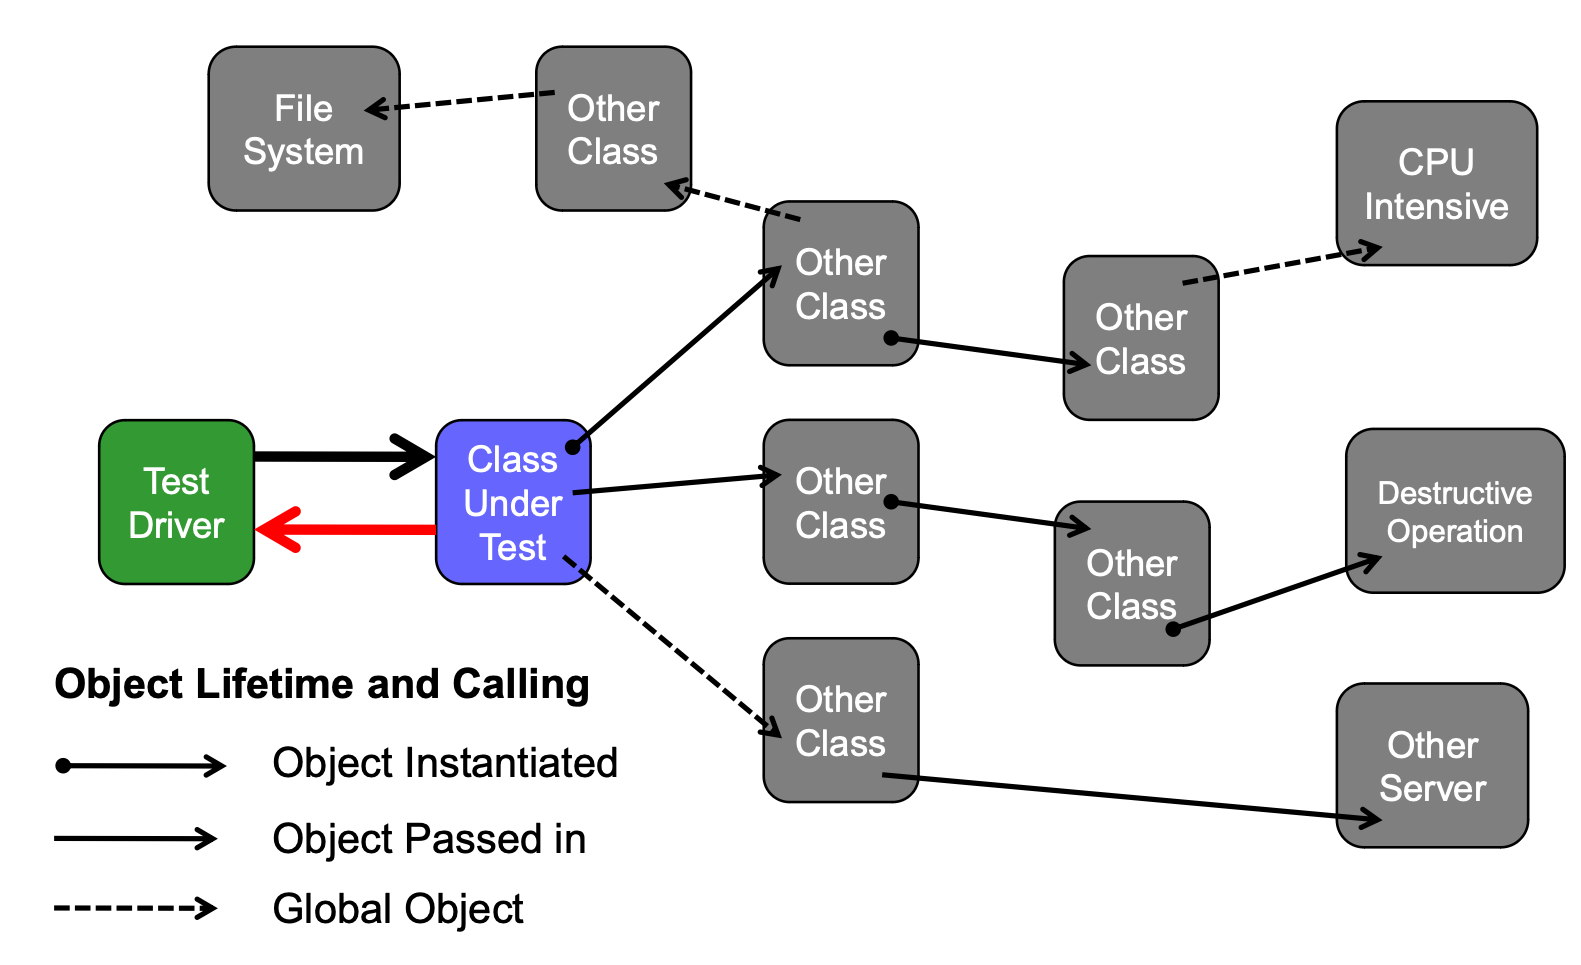

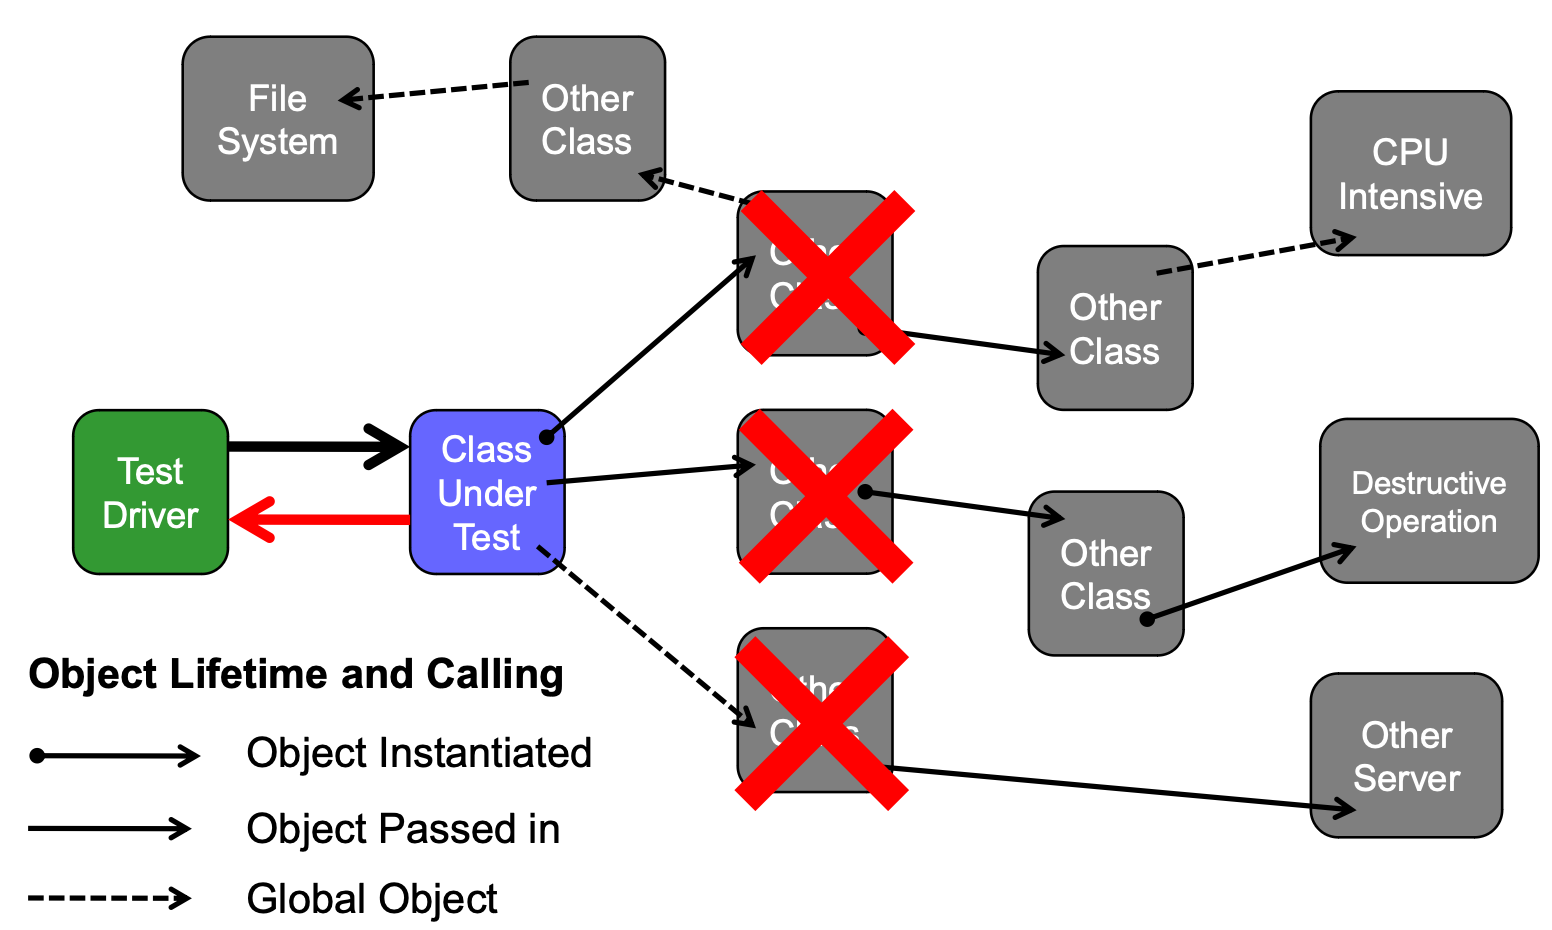

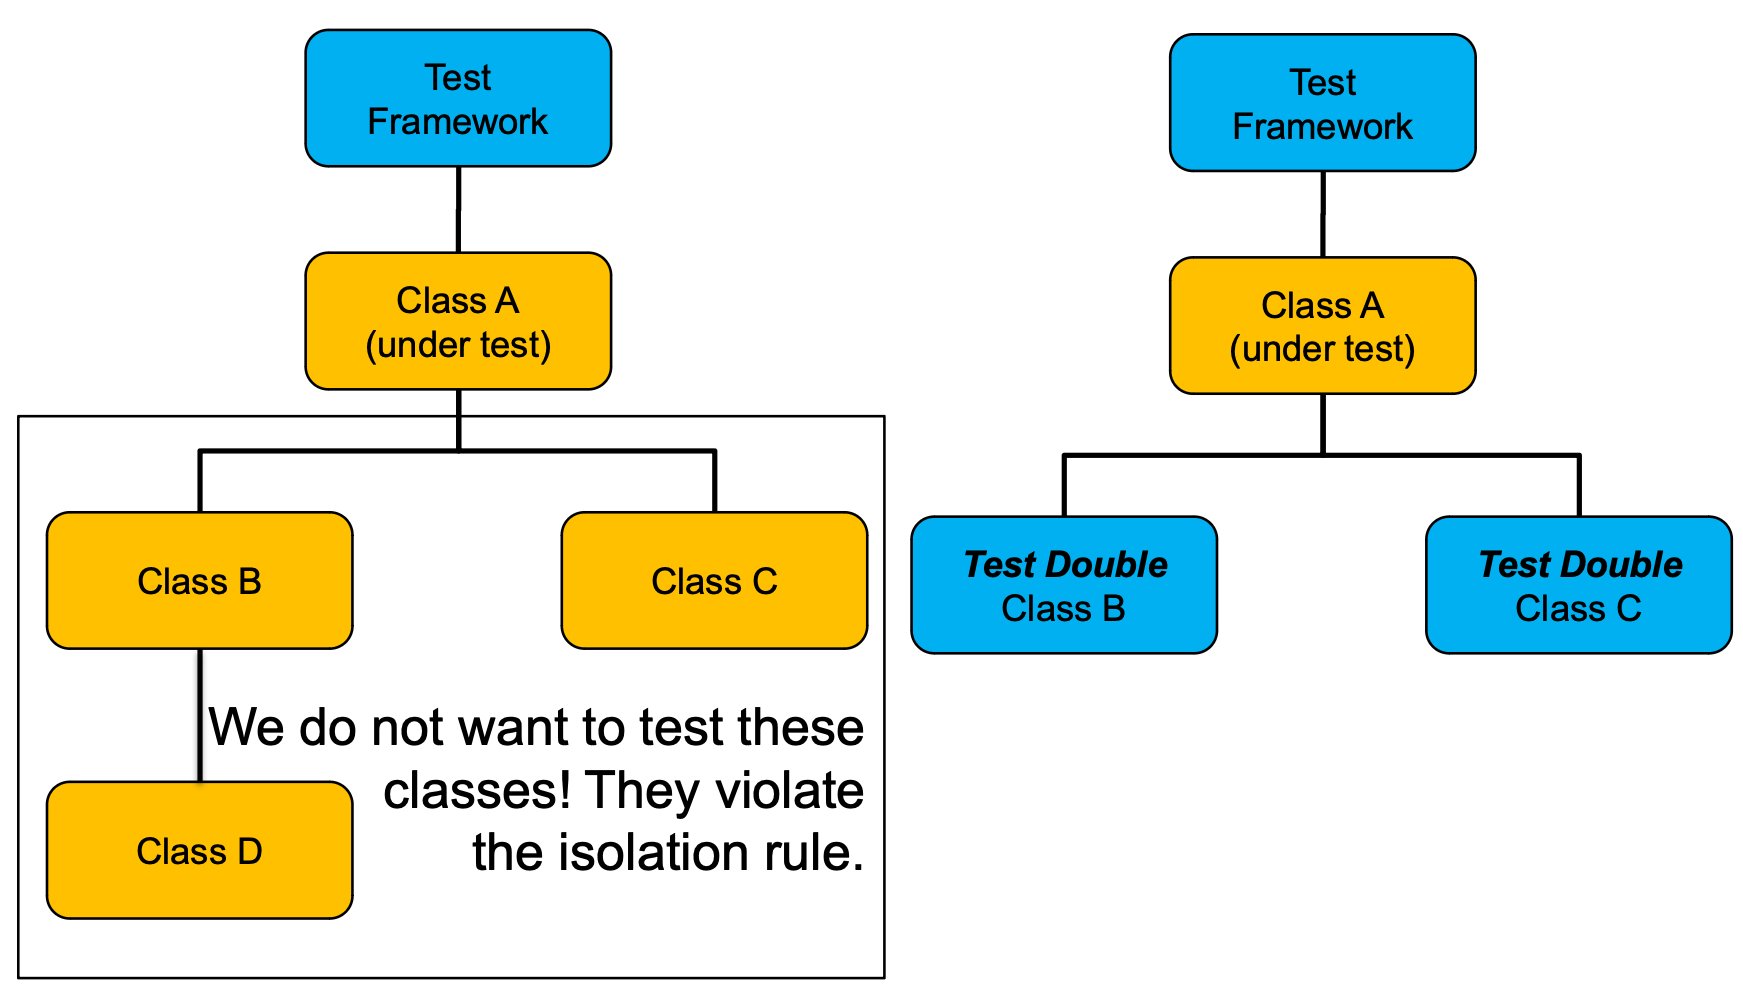

__Testing the stability of the Class Under Test:__ The primary goal here is to ensure that the class behaves as expected across a range of inputs and scenarios. This includes handling success and error responses correctly, managing exceptions, and executing its logic (like deciding to execute an order based on certain conditions) based on mocked inputs.

__Why not use Mockito or similar?:__ Since the original example is in Python, we use unittest.mock, which is the standard mocking framework provided in Python's standard library. Mockito is a popular choice for mocking in Java but doesn't apply to Python. For Python, alternatives to unittest.mock could include third-party libraries like [`pytest-mock`](https://pytest-mock.readthedocs.io/en/latest/), which integrates with the pytest framework to provide a more powerful and flexible mocking experience. However, for many use cases, especially those illustrated in the example, `unittest.mock` is sufficient and does not require additional dependencies.

In [6]:
class TradingAPI:
    def __init__(self, base_url):
        self.base_url = base_url

    def get_price(self, ticker):
        """Get the current price of the stock."""
        response = requests.get(f"{self.base_url}/price/{ticker}")
        if response.status_code == 200:
            return response.json()['price']
        else:
            raise Exception("Failed to retrieve data")

    def execute_order(self, ticker, quantity, action):
        """Execute a buy/sell order."""
        order_data = {
            "ticker": ticker,
            "quantity": quantity,
            "action": action  # "buy" or "sell"
        }
        response = requests.post(f"{self.base_url}/order", json=order_data)
        if response.status_code == 200:
            return response.json()['order_status']
        else:
            raise Exception("Order execution failed")


In [7]:
class TestTradingAPI(unittest.TestCase):
    @patch('requests.get') 
    # If above class is saved as trading_api.py, when this get @patch('trading_api.requests.get')
    def test_get_price_success(self, mock_get):
        # Simulate a successful API response
        mock_get.return_value.status_code = 200
        mock_get.return_value.json.return_value = {'price': 100.0}

        api = TradingAPI('https://fakeapi.com')
        price = api.get_price('AAPL')
        self.assertEqual(price, 100.0)

    @patch('requests.get')
    def test_get_price_failure(self, mock_get):
        # Simulate a failed API response
        mock_get.return_value.status_code = 404

        api = TradingAPI('https://fakeapi.com')
        with self.assertRaises(Exception):
            api.get_price('AAPL')

    @patch('requests.post')
    def test_execute_order_success(self, mock_post):
        # Simulate a successful order execution response
        mock_post.return_value.status_code = 200
        mock_post.return_value.json.return_value = {'order_status': 'executed'}

        api = TradingAPI('https://fakeapi.com')
        order_status = api.execute_order('AAPL', 10, 'buy')
        self.assertEqual(order_status, 'executed')

    # Add more tests as needed for different scenarios, like failed order execution, partial fills, etc.

In [8]:
if __name__ == '__main__':
    unittest.main(argv=[''], exit=False)

........
----------------------------------------------------------------------
Ran 8 tests in 0.004s

OK


When we use `@patch('trading_api.requests.get')` and `@patch('trading_api.requests.post')`, what happens is that any call to `requests.get` or `requests.post` within the `TradingAPI` class is intercepted by the mock. This means that when the `get_price` or `execute_order` method is called, the actual network request is never made. Instead, the mock object created by patch is used, and its behavior (like what it returns or raises) is controlled by our test setup.

In the test methods, we configure the mock objects (`mock_get` and `mock_post`) to simulate specific responses from the requests library. For example, `mock_get.return_value.status_code = 200` and `mock_get.return_value.json.return_value = {'price': 100.0}` simulate a successful HTTP response with a status code of 200 and a JSON body containing a stock price. This setup allows us to test how `TradingAPI` handles different responses without making real HTTP requests.

The URL `https://fakeapi.com` used in TradingAPI(`https://fakeapi.com`) is irrelevant to the outcome of the test. It serves as a placeholder to instantiate the `TradingAPI` object, demonstrating how the class is meant to be used with a base URL. Since all calls to `requests.get` and `requests.post` are mocked, no actual request is sent to this URL.

The use of the mock ensures that the tests __are not dependent on external factors__ like network connectivity or the availability of an external API. This allows the tests to be __fast, reliable, and repeatable__.

The essence of mocking in these tests is to verify that `TradingAPI` correctly interprets and acts on the simulated responses from the `requests` library, such as processing successful responses, handling HTTP errors, and raising exceptions as defined in the class's logic.

## Spies and Stubs 


In the context of testing, especially when using mocking frameworks like `pytest` along with its mocking capabilities (often enhanced with plugins like `pytest-mock`), it's helpful to understand various concepts such as "mocks," "stubs," and "spies." These tools are essential for creating effective unit tests that can simulate interactions with dependencies or external services without making real calls or executions. 

### Stubs

Stubs are __simplified implementations of functions, methods, or objects__ that replace parts of your system under test. Their primary purpose is to return pre-defined responses to calls made during tests. They're used to simulate the behavior of complex or unwieldy dependencies with a much simpler, controlled interface. In pytest, you can create a stub by simply using a `Mock object` from the `unittest.mock` module (which is what `pytest-mock` leverages under the hood) and configuring it to return a specific value.

For example, you might stub an API client's method that fetches data from a remote service by returning a fixed dataset suitable for your test scenario:

In [9]:
def test_my_function(mocker):
    # Create a stub for the 'get_data' method
    stub = Mock(return_value={'key': 'value'})
    mocker.patch('path.to.my.module.ApiClient.get_data', new=stub)
    
    # Now, when my_function calls ApiClient.get_data, it will receive {'key': 'value'}
    assert my_function_that_uses_get_data() == expected_result


### Spies

Spies are a bit more sophisticated than stubs. They record information about how a function or method was called, such as the arguments it received and how many times it was called, without necessarily altering its behavior. This is useful for verifying that certain interactions took place without disrupting the normal operation of your system under test.

In `pytest`, while there's no built-in "spy" as in some other testing frameworks (like Jasmine for JavaScript), you can achieve similar functionality using the `Mock` or `MagicMock` classes from `unittest.mock` by configuring them to wrap the original function or method. This way, you can inspect calls to it.

Here’s an approach using pytest-mock that resembles spying:


In [10]:
def test_my_function_with_spy(mocker):
    # Wrap the original function with a mock to act as a spy
    original_function = my.module.function_to_spy_on
    spy = MagicMock(wraps=original_function)
    mocker.patch('my.module.function_to_spy_on', new=spy)
    
    # Run the test
    result = my_function_that_calls_function_to_spy_on()
    
    # Verify the spy was called as expected
    spy.assert_called_once_with(expected_arguments)
    assert result == expected_result


## Testing Edge Cases

Testing edge cases is a crucial part of software development, especially in finance, where handling data accurately and reliably is paramount. Edge cases are scenarios that occur at the extreme ends of operating parameters, which might include unusual, invalid, or rare inputs that could cause the system to behave unexpectedly. Testing these cases ensures that the system can handle a wide range of inputs gracefully, without crashing or producing incorrect results. This is particularly important in finance for reasons such as regulatory compliance, financial accuracy, risk management, and user trust.

### Example: Calculating the Adjusted Closing Price of Stocks

Imagine you're developing a system that calculates the adjusted closing price of stocks for a portfolio management application. The adjusted closing price reflects a stock's value after accounting for actions like dividends, splits, and mergers, providing a better picture of its value over time.

Why Test Edge Cases?

- __Handling Corporate Actions:__
    - Dividends: What happens if a dividend is mistakenly entered as a negative number?
    - Stock Splits: How does the system handle a stock split ratio of 0 or a negative number?

- __Historical Data Anomalies:__
    - Missing Data: How does the system calculate adjustments if there's missing data for certain dates?
    - Out-of-Order Data: What if the data source provides information in a non-chronological order?

- __Extreme Market Events:__
    - High Volatility: How does the system handle extremely high volatility, where stock prices might fluctuate wildly within a very short period?
    - Circuit Breakers: How are trading halts (circuit breakers) reflected in the adjusted prices?

### Mock Test Scenario: Handling a Stock Split with a Ratio of 0

Let's say you want to test how your system handles a stock split with a ratio of 0—an unrealistic scenario, but a good edge case to ensure your system can handle unexpected inputs without crashing.

In [11]:
class TestStockAdjuster(unittest.TestCase):
    def test_stock_split_with_zero_ratio(self):
        adjuster = StockAdjuster()
        with self.assertRaises(ValueError):
            adjuster.adjust_for_split(stock_symbol="XYZ", split_ratio=0)

# run test with unittest.main()

In this mock test, you're ensuring that if a stock split ratio of 0 is somehow entered into the system (perhaps through a data entry error or a glitch in data sourcing), the system raises a ValueError instead of performing an impossible calculation or, worse, crashing. This helps maintain data integrity and prevents the propagation of erroneous calculations through the system.

## Design Patterns

Software design patterns provide a way to structure and organize code, making it more readable, maintainable, and reusable. This can lead to a more efficient and scalable solution for financial models, as well as making it easier to test and debug code. In addition, design patterns help ensure that code meets best practices and industry standards, which can enhance the reliability and performance of financial models.

Furthermore, a solid understanding of software design patterns can also help to communicate and collaborate more effectively with software engineers and developers. This can lead to more efficient and effective solutions for financial models, as well as help build better relationships between different teams within a financial institution.


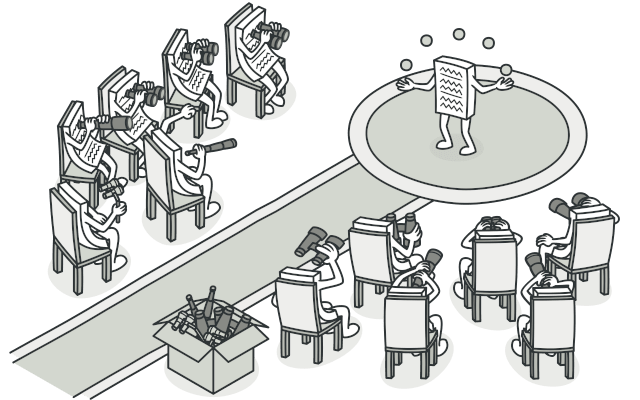

Link with information about design patterns in Python: https://refactoring.guru/design-patterns/python

In [12]:
class Observer:
    def update(self, stock_price):
        pass

class StockMarket(Observer):
    def __init__(self, name, symbol):
        self.name = name
        self.symbol = symbol
        self.price = None
        self.prev_price = None
    
    def update(self, stock_price):
        self.prev_price = self.price
        self.price = stock_price
        print(f"{self.name} ({self.symbol}) updated price: {self.price}")
        
        if self.prev_price is not None:
            price_change = (self.price - self.prev_price) / self.prev_price * 100
            if price_change < -10:
                print(f"{self.name} ({self.symbol}) price dropped more than 10%! Consider selling.")

In [13]:
class DataSource:
    def __init__(self):
        self.observers = []
    
    def add_observer(self, observer):
        self.observers.append(observer)
    
    def remove_observer(self, observer):
        self.observers.remove(observer)
    
    def update_observers(self, stock_price):
        for observer in self.observers:
            observer.update(stock_price)

def get_stock_prices(symbol, period="5d"):
    stock = yf.Ticker(symbol)
    stock_prices = stock.history(period=period)["Close"]
    return stock_prices

In [14]:
# Create instances of stocks and add them as observers to the data source
apple = StockMarket("Apple", "AAPL")
amazon = StockMarket("Amazon", "AMZN")
google = StockMarket("Google", "GOOG")

data_source = DataSource()
data_source.add_observer(apple)
data_source.add_observer(amazon)
data_source.add_observer(google)

In [15]:
# Download and update the stock prices
apple_prices = get_stock_prices("AAPL")
amazon_prices = get_stock_prices("AMZN")
google_prices = get_stock_prices("GOOG")


In [16]:
for apple_price, amazon_price, google_price in zip(apple_prices, amazon_prices, google_prices):
    data_source.update_observers(apple_price)
    data_source.update_observers(amazon_price)
    data_source.update_observers(google_price)
    time.sleep(1)

Apple (AAPL) updated price: 191.72999572753906
Amazon (AMZN) updated price: 191.72999572753906
Google (GOOG) updated price: 191.72999572753906
Apple (AAPL) updated price: 161.25999450683594
Apple (AAPL) price dropped more than 10%! Consider selling.
Amazon (AMZN) updated price: 161.25999450683594
Amazon (AMZN) price dropped more than 10%! Consider selling.
Google (GOOG) updated price: 161.25999450683594
Google (GOOG) price dropped more than 10%! Consider selling.
Apple (AAPL) updated price: 154.83999633789062
Amazon (AMZN) updated price: 154.83999633789062
Google (GOOG) updated price: 154.83999633789062
Apple (AAPL) updated price: 188.0399932861328
Amazon (AMZN) updated price: 188.0399932861328
Google (GOOG) updated price: 188.0399932861328
Apple (AAPL) updated price: 159.0
Apple (AAPL) price dropped more than 10%! Consider selling.
Amazon (AMZN) updated price: 159.0
Amazon (AMZN) price dropped more than 10%! Consider selling.
Google (GOOG) updated price: 159.0
Google (GOOG) price drop